In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, sub_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        self.sub_no = sub_no
        
        #self.lstm = nn.GRU(self.in_no, self.H_no, self.layer_no, batch_first=True)
        #self.linear = nn.Linear(self.H_no, 1)
        
        self.scale = nn.Parameter(torch.ones(self.in_no), requires_grad=True)
        
        self.rnn = nn.ModuleList()
        self.linear = nn.ModuleList()
        for s in range(self.sub_no):
            self.rnn.append(nn.GRU(1, self.H_no, self.layer_no, batch_first=True))
            self.linear.append(nn.Linear(self.H_no, 1))
        
        self.clust_raw = nn.Parameter(torch.zeros(self.sub_no, self.in_no), requires_grad=True)
        
    def forward(self, S, temp, test):
        T_data = S.shape[0]
        
        S = S * self.scale.reshape(1,-1)
        
        if test == False:
            W_clust = F.softmax(self.clust_raw/temp, 0)
        elif test == True:
            W_clust = torch.zeros_like(self.clust_raw).to(self.device)
            for i in range(W_clust.shape[1]):
                idx = torch.argmax(self.clust_raw[:,i])
                W_clust[idx,i] = 1
        
        sub_out = torch.zeros(T_data, self.sub_no).to(self.device)
        
        for s in range(self.sub_no):
            sub_in = torch.matmul(S, W_clust[s]) #(T_data)
            rnn_out, _ = self.rnn[s](sub_in.reshape(1,-1,1))
            sub_out[:,s] = sub_out[:,s] + self.linear[s](rnn_out.squeeze(0)).flatten()
        
        final = torch.sum(sub_out, 1)
        
        return final, sub_out, W_clust

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [4]:
T_train = 149 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 20
layer_no = 1
sub_no = 4
#in_no = e_idx.shape[0] + i_idx.shape[0]
in_no = 299
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 50000
iter_no = 20000
epoch_no = iter_no*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = GenericGRU(T_no, H_no, layer_no, in_no, sub_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.006)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

7099


In [ ]:
temp_list = np.logspace(-0.5, -3, 100)
temp_count = 0
#print(temp_list)

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    if (i%25 == 24) & (temp_count < 99):
        temp_count += 1
        print(temp)
    temp = temp_list[temp_count] 
    
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    #V_pred, _, __ = model(torch.hstack((batch_E_neural[:,e_idx], batch_I_neural[:,i_idx])), temp, False)
    V_pred, _, __ = model(batch_E_neural[:,e_idx], temp, False)
    #V_pred = model(torch.hstack((batch_E_neural, batch_I_neural)))
    
    train_score = explained_variance_score(batch_V.cpu().detach().numpy(), V_pred.cpu().detach().numpy())
            
    #loss = torch.var(V_pred - batch_V)
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        #test_V_pred, test_sub_out, test_W_clust = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])), temp, True)
        test_V_pred, test_sub_out, test_W_clust = model(test_E_neural[:,e_idx], temp, True)
        #test_V_pred = model(torch.hstack((test_E_neural, test_I_neural)))
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        
        clust_loss = torch.mean(torch.abs(test_W_clust[:,1:] - test_W_clust[:,:-1])).item()
        
        print(i, np.round(test_score,6),
              np.round(test_mse,6),
              np.round(train_score,6),
              np.round(loss.item(),6),
              np.round(clust_loss,6))


<ipython-input-7-a5e42d2e0e1d>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.009796 0.054577 -0.014163 0.032932 0.206376
0.31622776601683794
0.29836472402833386
49 0.131766 0.023614 0.103796 0.025604 0.075503
0.28151072774477304
0.2656087782946686
99 0.211361 0.021663 0.266821 0.019826 0.09396
0.2506050965530081
0.23644894126454072
149 0.250014 0.021461 0.281086 0.021916 0.10906
0.2230924374408983
0.21049041445120203
199 0.265048 0.020031 0.260616 0.021165 0.105705
0.19860025325859118
0.1873817422860384
249 0.296207 0.01981 0.284252 0.014235 0.115772
0.176796941424003
0.16681005372000587
299 0.296619 0.019183 0.280435 0.020023 0.110738
0.15738730431619036
0.1484968262254465
349 0.303245 0.01897 0.246777 0.025246 0.13255
0.14010855255980165
0.1321941148466029
399 0.309994 0.018974 0.331055 0.01799 0.14094
0.12472674708860454
0.11768119524349985
449 0.308764 0.018879 0.36257 0.015313 0.152685
0.11103363181676379
0.10476157527896648
499 0.321735 0.018624 0.327446 0.026224 0.174497
0.0988438140350333
0.093260334688322
549 0.33121 0.018191 0.311288 0.024562 0.17

6249 0.538713 0.012546 0.543595 0.013132 0.169463
6299 0.535138 0.012645 0.51528 0.011549 0.169463
6349 0.54126 0.012476 0.560594 0.009684 0.169463
6399 0.533472 0.012688 0.540131 0.012029 0.169463
6449 0.532723 0.012709 0.47268 0.016483 0.169463
6499 0.535372 0.012643 0.466177 0.013343 0.169463
6549 0.53812 0.012562 0.447748 0.018793 0.169463


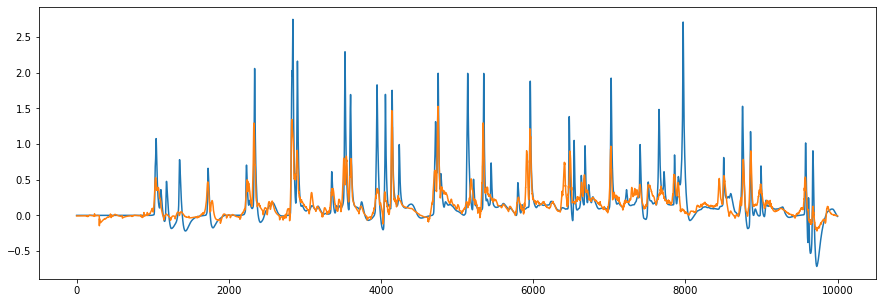

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])
#plt.plot(lin_out.flatten().cpu().detach().numpy()[16000:26000])

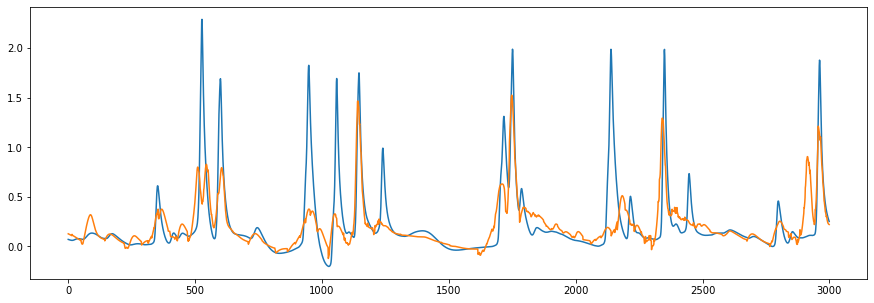

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:6000])

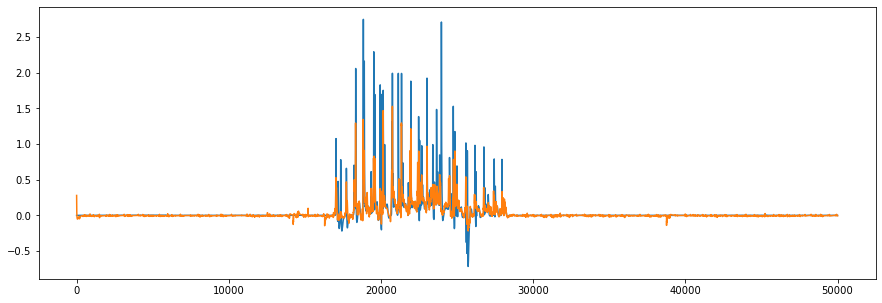

In [11]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())

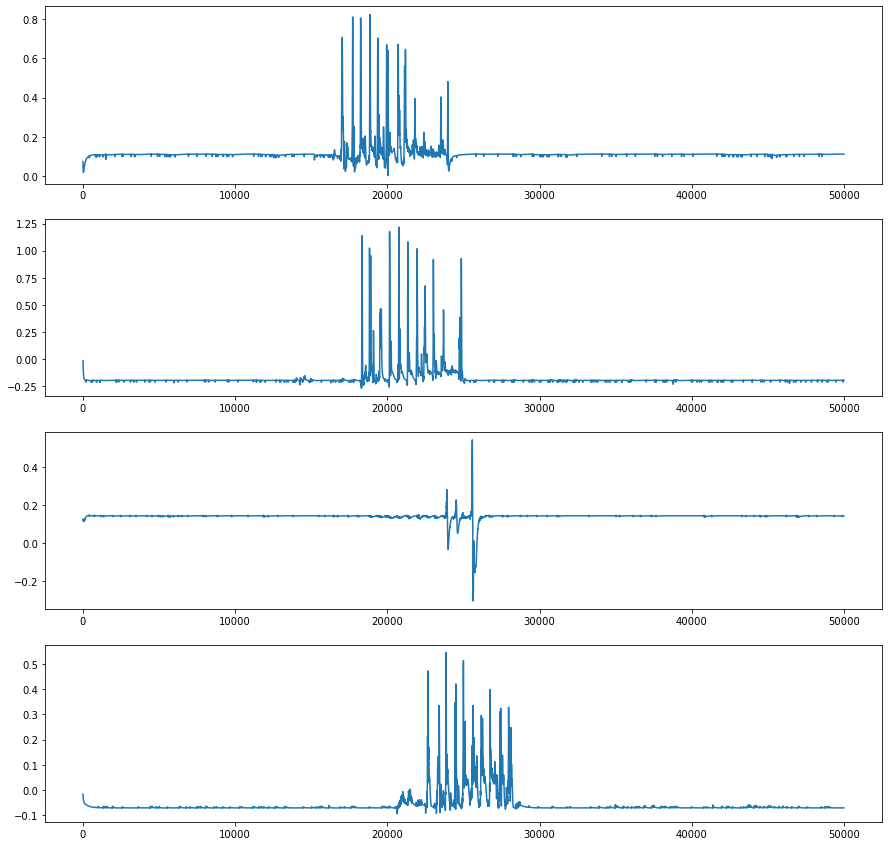

In [12]:
fig, axs = plt.subplots(nrows=sub_no, figsize = (15,15))
for i in range(sub_no):
    axs[i].plot(test_sub_out[:,i].cpu().detach().numpy())

In [58]:
idx = 1

sub_v = test_sub_out[:,idx].cpu().detach().numpy()
den_loc = np.where(eloc[:,0] == den_idx[idx])[0]
sub_spk_raw = test_E_neural[:,den_loc].cpu().detach().numpy()
sub_spk = np.zeros((int(np.sum(sub_spk_raw)), 2))

count = 0
for t in tnrange(sub_spk_raw.shape[0]):
    spk_idx = np.where(sub_spk_raw[t]  == 1)[0]
    for s in range(spk_idx.shape[0]):
        sub_spk_idx = spk_idx[s]
        sub_spk[count,0] = t
        sub_spk[count,1] = sub_spk_idx
        count += 1
    

#sub_spk = np.zeros((sub_spk_raw.shape[0]))
#for t in range(sub_spk.shape[0]):
    #spk_idx = np.where(sub_spk_raw[t]  == 1)[0]
    #for s in range(spk_idx.shape[0]):
        #sub_spk_idx

<ipython-input-58-83c65040bfce>:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for t in tnrange(sub_spk_raw.shape[0]):


(18000.0, 24000.0)

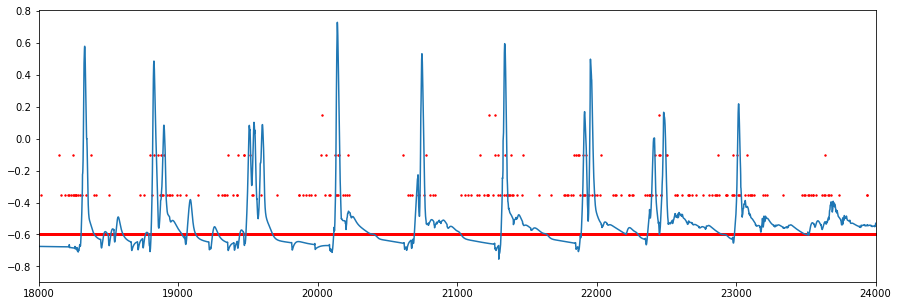

In [62]:
plt.figure(figsize = (15,5))
plt.plot(sub_v)
plt.scatter(np.arange(psth.shape[0]), psth*0.25-0.6 , s=2, c="red")
plt.xlim(18000,24000)

(16000.0, 22000.0)

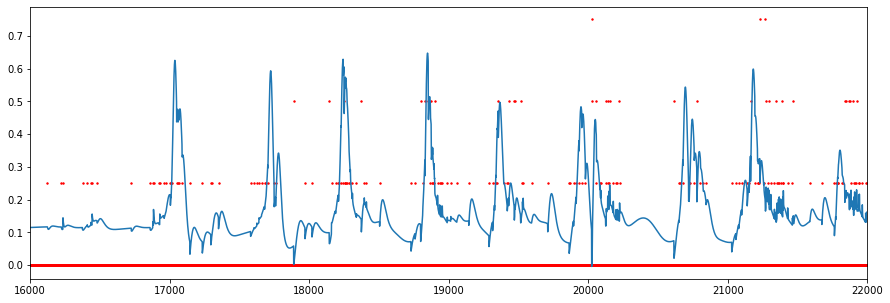

In [57]:
plt.figure(figsize = (15,5))
plt.plot(sub_v)
plt.scatter(np.arange(psth.shape[0]), psth*0.25 , s=2, c="red")
plt.xlim(16000,22000)

In [102]:
t = np.arange(0,100)
t_tau = t / 5
kern = t_tau * np.exp(-t_tau)
#kern = np.flip(kern)

conv = np.convolve(kern, psth, "same")


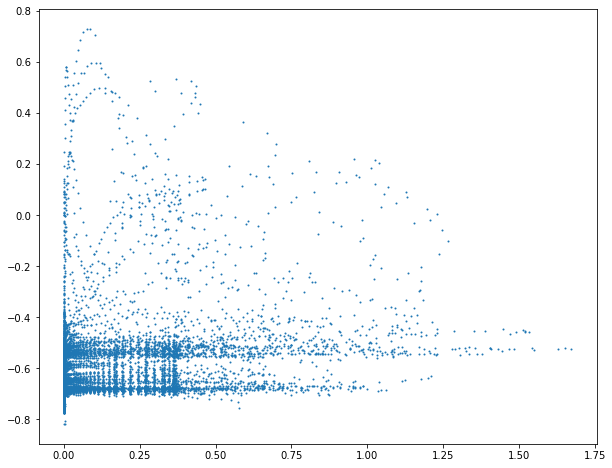

In [103]:
plt.figure(figsize = (10,8))
plt.scatter(conv, sub_v, s=1)

(16000.0, 22000.0)

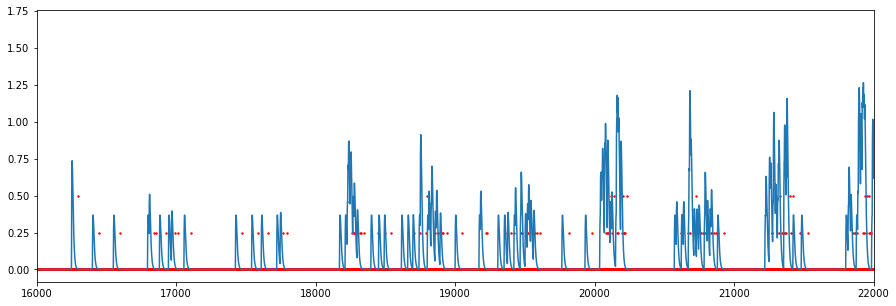

In [104]:
plt.figure(figsize = (15,5))
plt.plot(conv)
plt.scatter(np.arange(psth.shape[0]), psth*0.25 , s=2, c="red")
plt.xlim(16000,22000)

(16000.0, 22000.0)

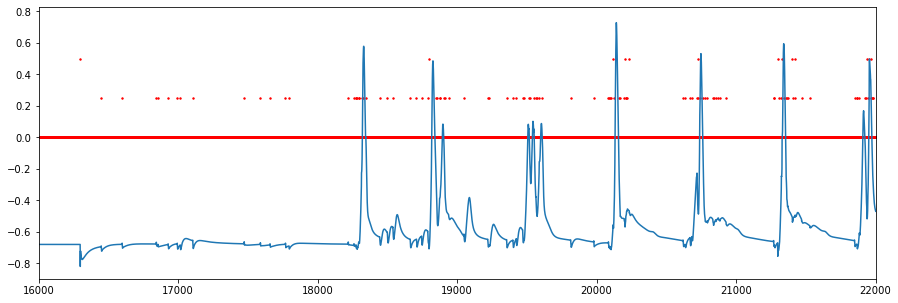

In [105]:
plt.figure(figsize = (15,5))
plt.plot(sub_v)
plt.scatter(np.arange(psth.shape[0]), psth*0.25 , s=2, c="red")
plt.xlim(16000,22000)